In [1]:
import pandas as pd

In [2]:
candidates = pd.read_csv('./dressipi_recsys2022/candidate_items.csv')
candidates

,item_id
0,4
1,8
2,9
3,19
4,20
...,...
4985,28128
4986,28131
4987,28132
4988,28133


In [3]:
items = pd.read_csv('./dressipi_recsys2022/item_features.csv')
items

,item_id,feature_category_id,feature_value_id
0,2,56,365
1,2,62,801
2,2,68,351
3,2,33,802
4,2,72,75
...,...,...,...
471746,28143,68,351
471747,28143,55,390
471748,28143,11,109
471749,28143,73,91


In [4]:
from datetime import datetime


def dateparse(date):    
    return int(datetime.strptime(date.split('.')[0], '%Y-%m-%d  %H:%M:%S').timestamp())

train_purchases = pd.read_csv('./dressipi_recsys2022/train_purchases.csv', parse_dates=[2])

# train_purchases['ts'] = train_purchases['date'].astype('int64')
train_purchases

,session_id,item_id,date
0,3,15085,2020-12-18 21:26:47.986
1,13,18626,2020-03-13 19:36:15.507
2,18,24911,2020-08-26 19:20:32.049
3,19,12534,2020-11-02 17:16:45.920
4,24,13226,2020-02-26 18:27:44.114
...,...,...,...
999995,4439986,2915,2021-05-13 11:56:37.464
999996,4439990,8786,2020-08-22 14:28:22.382
999997,4439994,21630,2020-11-27 20:10:28.961
999998,4439999,16962,2020-11-27 11:01:41.356


In [5]:
train_sessions = pd.read_csv('./dressipi_recsys2022/train_sessions.csv', parse_dates=[2])
train_sessions

,session_id,item_id,date
0,3,9655,2020-12-18 21:25:00.373
1,3,9655,2020-12-18 21:19:48.093
2,13,15654,2020-03-13 19:35:27.136
3,18,18316,2020-08-26 19:18:30.833
4,18,2507,2020-08-26 19:16:31.211
...,...,...,...
4743815,4440001,20409,2020-10-30 23:37:20.658
4743816,4440001,14155,2020-10-30 23:31:56.607
4743817,4440001,14303,2020-10-30 23:36:17.934
4743818,4440001,27852,2020-10-30 23:39:55.186


In [6]:
test_leaderboard_sessions = pd.read_csv('./dressipi_recsys2022/test_leaderboard_sessions.csv')
test_leaderboard_sessions

,session_id,item_id,date
0,26,19185,2021-06-16 09:53:54.158
1,200,17089,2021-06-25 12:23:40.811
2,200,17089,2021-06-25 12:24:36.631
3,200,8060,2021-06-25 12:24:41.677
4,200,4758,2021-06-25 12:24:50.692
...,...,...,...
229349,4439653,25955,2021-06-11 10:22:57.47
229350,4439653,12179,2021-06-11 10:23:00.663
229351,4439757,2078,2021-06-30 11:42:15.073
229352,4439757,2078,2021-06-30 11:43:13.725


# Embedding items
Items are represented in a sparse format with the id of the feature and its value. We have no information on whether or not it is categorical or numerical, or the number of features. We want to explore them a little bit and find a compact representation.

First we want to know the coverage of each feature. Do a plot with, in x-axis, the feature id, and in y-axis, the number of non-null values.

In [7]:
from matplotlib import pyplot as plt
import numpy as np

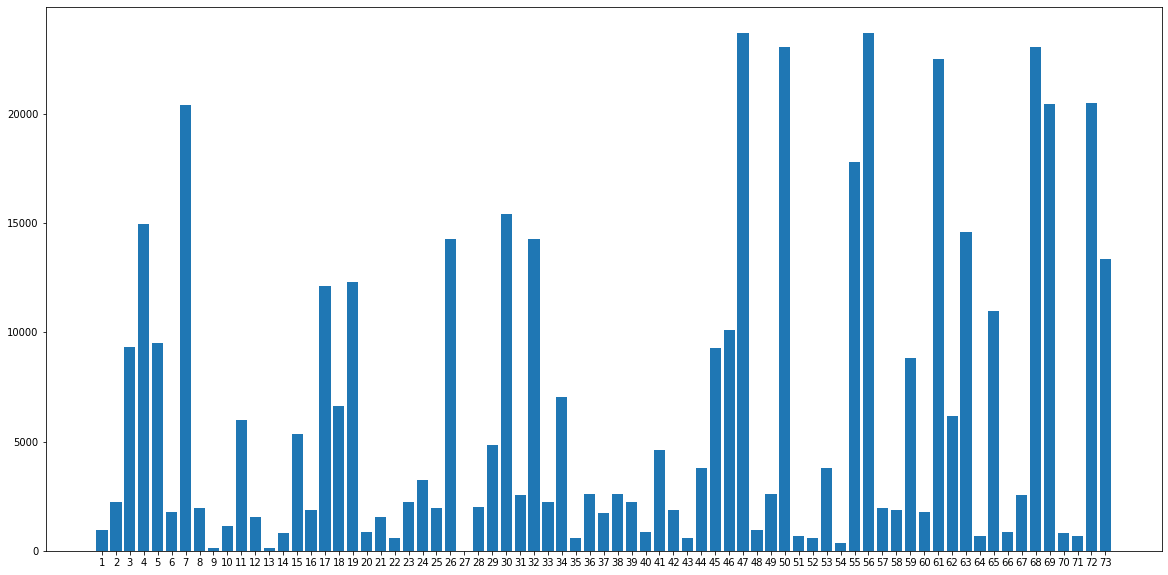

In [8]:
feature_id_count = items.groupby(['feature_category_id']).size().reset_index(name='counts')
fig, ax = plt.subplots(figsize = (20,10))
ax.bar(feature_id_count['feature_category_id'], feature_id_count['counts'])
ax.set_xticks(np.arange(1, feature_id_count['feature_category_id'].max() + 1, step=1))
plt.show()

73 features is not that much, let's see how each of them look. Display the counts / min / max / std for each feature. You should see that one feature is useless, remove it!

In [9]:
items.groupby("feature_category_id")["feature_value_id"].describe().sort_values(by=["count"])

,count,mean,std,min,25%,50%,75%,max
feature_category_id,,,,,,,,
27,1.0,423.000000,NaN,423.0,423.0,423.0,423.0,423.0
9,137.0,223.635036,77.537171,175.0,175.0,190.0,190.0,369.0
13,137.0,580.554745,206.876701,252.0,252.0,698.0,698.0,905.0
54,341.0,760.448680,101.582889,197.0,785.0,785.0,785.0,785.0
52,568.0,551.839789,223.219225,227.0,293.0,728.0,756.0,756.0
...,...,...,...,...,...,...,...,...
61,22512.0,676.885528,154.116169,59.0,706.0,706.0,706.0,898.0
68,23038.0,443.496050,230.800434,10.0,351.0,373.0,702.0,903.0
50,23077.0,483.046757,285.430458,8.0,240.0,328.0,708.0,901.0


In [10]:
items = items.drop(items[items.feature_category_id == 27].index)

If 73 features is not a lot, it is still a big number given the number of samples for your poor laptop if you make it dense. It is also good practice to preprocess the data into a set of embeddings without sparse format because most ML algorithm do not handle sparse. We want to do it now. Use TruncatedSVD from scikit-learn with n_components = 12 (or less depending on your memory) and compute embeddings for your items.

In [11]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import coo_matrix


items_matrix = coo_matrix((items["feature_value_id"], (items["item_id"], items["feature_category_id"])))
items_matrix

<28144x74 sparse matrix of type '<class 'numpy.int64'>'
	with 471750 stored elements in COOrdinate format>

In [12]:
svd = TruncatedSVD(n_components=12)
svd.fit(items_matrix)
df = pd.DataFrame(svd.transform(items_matrix))
df.shape

(28144, 12)

You now have a matrix of dimension (28144, n_components) representing the items.

In [13]:
df

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,794.680184,377.343645,-303.561671,669.612876,487.114838,31.146413,179.065935,297.276798,-153.077020,-448.519522,-82.300448,45.775646
3,2387.218101,-924.921011,161.342832,-448.550065,-36.610185,-508.698489,-261.134548,140.721360,-136.650433,-86.553738,101.901262,-516.684974
4,2304.639154,-837.402437,194.342671,-143.934254,-183.789376,3.302210,190.620339,-170.639571,-157.195016,-63.521064,-371.898353,54.091347
...,...,...,...,...,...,...,...,...,...,...,...,...
28139,2496.719059,-681.709967,127.865503,94.363958,-141.323364,830.499592,-244.838302,-96.673295,366.967936,38.641393,-407.930288,-29.972360
28140,747.063373,532.023459,-1458.557353,-589.887970,-396.119663,6.414162,44.160562,-82.489904,-222.945838,-183.463450,81.545089,-79.098705
28141,2039.201872,-664.322599,27.056807,-712.698202,16.570355,17.022534,252.174927,-164.860525,-57.909095,-298.758857,-73.902169,-139.283563
28142,1472.569195,356.499022,-347.940109,38.524882,879.686044,493.900019,56.273004,12.014504,227.581779,-35.896940,-236.387673,-303.916464


# Embedding sessions

Sessions are defined by a series of items, we first want to see what they look like to be able to find a suitable representation for them.

My advice: start by sampling the train_sessions dataframe to keep 5% or 10% otherwise your memory may suffer.

Then plot the distribution of session sizes: x-axis is the size of the session, y-axis is the number of sessions of this size. Determine a threshold to contain completely 90% of the sessions. This is how we will compute the session representation.

In [14]:
sample = train_sessions.sample(frac=0.10, random_state=42)
sample

,session_id,item_id,date
1177821,1102367,13043,2020-04-15 01:58:28.674
3969416,3712749,6735,2020-10-30 13:05:04.617
24877,23678,18786,2021-05-29 14:07:39.570
2975055,2780725,20599,2021-03-21 16:31:15.721
3654824,3416917,20808,2020-06-09 08:13:40.117
...,...,...,...
640704,599637,2187,2020-11-16 10:43:00.866
4644008,4345780,6444,2020-09-28 11:17:03.469
2070404,1935317,4073,2021-03-01 12:07:37.455
719622,673031,15573,2021-02-04 23:06:52.203


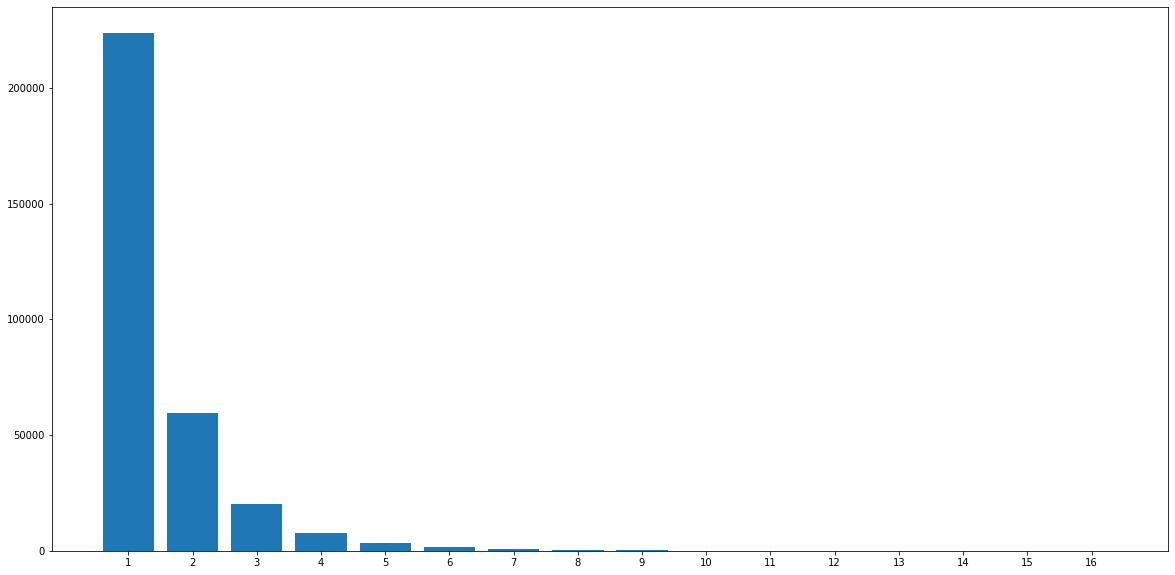

In [20]:
distribution = sample.groupby('session_id').size().reset_index(name='counts')
distribution = distribution.groupby('counts').size().reset_index(name='number')
fig, ax = plt.subplots(figsize = (20,10))
ax.bar(distribution['counts'], distribution['number'])
ax.set_xticks(np.arange(1, distribution['counts'].max() + 1, step=1))
plt.show()

Let $k$ be the length you have picked for your session. Create a vectorize representation of your sessions by either concatenating the embedding of the corresponding items, or averaging them (if memory is scarse).

In [16]:
sample.columns = sample.columns.to_flat_index()
sample

,session_id,item_id,date
1177821,1102367,13043,2020-04-15 01:58:28.674
3969416,3712749,6735,2020-10-30 13:05:04.617
24877,23678,18786,2021-05-29 14:07:39.570
2975055,2780725,20599,2021-03-21 16:31:15.721
3654824,3416917,20808,2020-06-09 08:13:40.117
...,...,...,...
640704,599637,2187,2020-11-16 10:43:00.866
4644008,4345780,6444,2020-09-28 11:17:03.469
2070404,1935317,4073,2021-03-01 12:07:37.455
719622,673031,15573,2021-02-04 23:06:52.203


# Embedding purchases
Purchases are one item, so we simply use their embedding. However, we also need to add negative samples so that our model not only learn on positives (One class SVM can do this, but those models are not known to generalize well...). In order to generate negative samples, shuffle the item_id columns of 4 copies of the purchase array. The original values have a label 1, the copies that have been shuffled have a value of 0.

In [17]:
all_purchases = df.merge(all_purchases, right_on='item_id', left_index=True).drop('item_id', axis=1)
all_purchases

NameError: name 'all_purchases' is not defined

In [ ]:
del train_purchases, negative_train_purchases

# Merge everything

We merge the whole dataset together to fit a model. For each session we concatenate:
* The history of the user
* The purchase embedding, with the label

We will have our training set!

# Learn a model and predict on test

This is it. You have now a dataset that you can directly pass to a LogisticRegression. For the testing part, perform your prediction on all candidates and pick the hundred ones that have the highest results.

# Going further

Your next task is to have an RNN running on this dataset. Take a look at [this notebook](https://github.com/oakfr/intro-to-reco/blob/master/application/part_2/RNN-next-item-prediction.ipynb) and adapt it to your usecase!

You are now ready to start the project. Take a look at the packages [surprise](http://surpriselib.com/) and [Microsoft recommenders](https://github.com/microsoft/recommenders) to find models available out of the box.